# OU Feature Engineering
#### This notebook is for doing feature engineering for the supervised learning (classification) problem for our capstone

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
import importlib
import EDA_helpers
importlib.reload(EDA_helpers)

importing Jupyter notebook from EDA_helpers.ipynb
importing Jupyter notebook from EDA_helpers.ipynb


<module 'EDA_helpers' from 'EDA_helpers.ipynb'>

In [2]:
def get_data():
    assessments_raw = pd.read_csv("dataset/assessments.csv")
    courses_raw = pd.read_csv("dataset/courses.csv")
    student_assessment_raw = pd.read_csv("dataset/studentAssessment.csv")
    student_info_raw = pd.read_csv("dataset/studentInfo.csv")
    student_registration_raw = pd.read_csv("dataset/studentRegistration.csv")
    # If this is failing, ensure that you have downloaded the dataset and copied studentVle.csv 
    # to the dataset folder.
    student_vle_raw = pd.read_csv("dataset/studentVle.csv") 
    vle_raw = pd.read_csv("dataset/vle.csv")

    return {
        "assessments_raw":assessments_raw,
        "courses_raw":courses_raw,
        "student_assessment_raw":student_assessment_raw,
        "student_info_raw":student_info_raw,
        "student_registration_raw":student_registration_raw,
        "student_vle_raw":student_vle_raw,
        "vle_raw":vle_raw
    }

In [3]:
# this is only used for testing purposes - comment out before saving as a module
# data_dict = get_data()
# si = data_dict["student_info_raw"]
# svle = data_dict['student_vle_raw']

In [4]:
# vle=data_dict['vle_raw']
# print(vle.shape)
#vle['activity_type'].value_counts()
#print(vle[vle['activity_type']=='repeatactivity'])
#svle[svle.id_site.isin([716420, 716409,716423, 883102, 883099])]

(6364, 6)


#### Add column indicating if student previously failed

In [38]:
def did_not_prev_pass(df):
    if len(df['final_result_y']) == 1:
        return False
    zipped = zip(df['code_presentation_y'], df['final_result_y'])
    
    # remove presentations that are at the same time of the current one or after
    curr_presentation = df['code_presentation_x']
    prior_final_results = [x[1] for x in zipped if x[0] < curr_presentation]

    dnp_set = {"Withdrawn", "Fail", 1,2}
    if len(dnp_set & set(prior_final_results)) > 0:
        return True
    return False
    
    

# create a column that indicates whether or not the student has previously withdrawn or failed
def add_col_student_prev_failed(student_info_df):
    '''
    Given the student info dataframe, add a column to indicate if the student had failed or 
    withdrawn in a previous class (not necessarily the class the student is currently enrolled in)
    '''
    si = student_info_df.copy()

    # this is a list of all students final results for each presentation
    si_grouped = si[['id_student','code_module','code_presentation','final_result']].groupby(['id_student']).agg(list).reset_index()
    merged = si.merge(si_grouped, left_on='id_student', right_on='id_student')
    merged['prev_failed_or_withdrawn'] = merged.apply(did_not_prev_pass, axis=1)

    #print(si_grouped.columns)
    #print(merged.columns)

    si = si.merge(
                merged[['id_student','prev_failed_or_withdrawn', 'code_presentation_x','code_module_x']], 
                left_on=['id_student','code_presentation','code_module'],
                right_on=['id_student','code_presentation_x','code_module_x']
            ).drop(
                columns=['code_presentation_x','code_module_x']
            )
    #si['has_prev_withdrawn_or_failed']
    return si

In [33]:
# #test that it doesn't change number of rows, and increases columns by 1
# si_test = si[si.id_student == 8462]
# si_prev_failed = add_col_student_prev_failed(si)
# print(si_prev_failed.shape)
# print(si.shape)
# #si_prev_failed.head()
# #si_prev_failed['prev_failed_or_withdrawn'].value_counts()
# #EDA_helpers.explore_df(si_prev_failed[si_prev_failed.prev_failed_or_withdrawn == True])
# si_prev_failed[si_prev_failed.prev_failed_or_withdrawn == True].head()

(32593, 13)
(32593, 12)


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,prev_failed_or_withdrawn
395,AAA,2014J,65002,F,East Anglian Region,A Level or Equivalent,70-80%,0-35,1,60,N,Fail,True
403,AAA,2014J,94961,M,South Region,Lower Than A Level,70-80%,35-55,1,60,N,Pass,True
415,AAA,2014J,129955,M,West Midlands Region,A Level or Equivalent,50-60%,0-35,1,60,N,Withdrawn,True
422,AAA,2014J,135335,F,East Anglian Region,Lower Than A Level,20-30%,0-35,1,120,N,Withdrawn,True
423,AAA,2014J,135400,F,South East Region,Lower Than A Level,90-100%,35-55,1,60,Y,Pass,True


In [36]:
# df[(df.code_presentation == '2014J') & (df.code_module == 'AAA')]
#si[si.id_student == 65002]
#si[(si.code_presentation == '2014J') & (si.code_module == 'AAA')]
# si[si.id_student == 129955]

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
41,AAA,2013J,129955,M,West Midlands Region,A Level or Equivalent,50-60%,0-35,0,60,N,Withdrawn
415,AAA,2014J,129955,M,West Midlands Region,A Level or Equivalent,50-60%,0-35,1,60,N,Withdrawn


In [6]:

# is the distribution of final_result of the students who have previously failed/withdrawn different from 
# the other students?
# Answer: it appears that they are different from the two plots. Commented out to make this notebook import friendly!

# import matplotlib.pyplot as plt

# si_prev_failed[si_prev_failed.prev_failed == False]['final_result'].value_counts().plot(kind='bar')

In [7]:
# si_prev_failed[si_prev_failed.prev_failed == True]['final_result'].value_counts().plot(kind='bar')

#### Add column indicating if student is minority

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import seaborn as sns 

# code adapted from: https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
def plot_NN_distances(df):
    distances = get_NN_distances_sorted(df)
    plt.plot(distances)

def get_NN_distances_sorted(df):
    num_students = df.shape[0]
    neigh = NearestNeighbors(n_neighbors=int(num_students*0.2))
    nbrs = neigh.fit(df)
    distances, indices = nbrs.kneighbors(df)
    distances = np.sort(distances, axis=0)
    distances = np.mean(distances[:,1:], axis=1)
    return distances


# code adapted from: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
def plot_pca(df, id_columns, label_column, axis):
    # plot dataframe using PCA and coloring on label_column
    df_copy = df.copy()
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df.drop(columns=id_columns + [label_column]).values)
    df_copy['pca-one'] = pca_result[:,0]
    df_copy['pca-two'] = pca_result[:,1]

    num_groups = len(df_copy[label_column].unique())
    sns.scatterplot(
        x='pca-one',
        y='pca-two',
        hue=label_column,
        palette=sns.color_palette('hls',num_groups),
        data=df_copy,
        ax=axis
    )

def plot_tsne(df, id_columns, label_column, axis):
    # plot df using tsne for dimension reduction and color on label_column
    df_copy = df.copy()
    tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=42)
    tsne_result = tsne.fit_transform(df.drop(columns=id_columns + [label_column]).values)
    df_copy['comp-1'] = tsne_result[:,0]
    df_copy['comp-2'] = tsne_result[:,1]

    num_groups = len(df_copy[label_column].unique())
    sns.scatterplot(x='comp-1',y='comp-2', hue=label_column, palette=sns.color_palette('hls',num_groups), data=df_copy, ax=axis)


In [17]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler

def add_col_demog_minority_in_course(student_info_df, use_og_maps=False):
    si = student_info_df.copy()
    og_cols = list(si.columns)
    id_columns = ['code_module','code_presentation','id_student']

    if use_og_maps:
        gender_map = {'M': 0, 'F': 3}
        ed_map = {'No Formal quals': 0, 'Lower Than A Level': 2, 'A Level or Equivalent': 4, 'HE Qualification': 5, 'Post Graduate Qualification': 6}
        disability_map = {'N': 0, 'Y': 3}
        age_map = {'0-35': 0, '35-55': 2, '55<=': 3}
    else:
        gender_map = {0: 0, 1: 3}
        ed_map = {0: 0, 1: 2, 2: 4, 3: 5, 4: 6}
        disability_map = {0: 0, 1: 3}
        age_map = {0: 0, 1: 2, 2: 3}
    # imd_band_map = {
    #     '0-10%':0,
    #     '10-20':0,
    #     '20-10%':1,
    #     '30-10%':2,
    #     '40-10%':2,
    #     '50-10%':2,
    #     '60-10%':2,
    #     '70-10%':2,
    #     '80-10%':3,
    #     '90-100%':3
    # }
    

    si["gender"]=si['gender'].map(gender_map)
    si["highest_education"]=si['highest_education'].map(ed_map)
    si["disability"]=si['disability'].map(disability_map)
    si["age_band"]=si['age_band'].map(age_map)
    # imd_band was dropped during joining - likely due to it being missing in much of the data.
    # si["imd_band"]=si['imd_band'].map(imd_band_map)
    # si['imd_band'].fillna(2, inplace=True)

    # student being a minority can different from class to class. Create a clustering 
    # for each module-presentation
    si_grouped = si.groupby(['code_module','code_presentation'])

    minority_columns = ['highest_education','age_band','disability','gender']

    df_class_list = [v for k,v in si_grouped]
    count = 0
    
    # uncomment if you want to see plots of the clusterings per class
    #fig, axs = plt.subplots(len(df_class_list),1, figsize=(10,len(df_class_list)*10))
    to_join = pd.DataFrame()
    for df in df_class_list:

        num_students = df.shape[0]
        distances = get_NN_distances_sorted(df[minority_columns].copy())
        eps_ = 0.3*distances[-1]
        clustering = DBSCAN(eps=eps_, min_samples=int(.05*num_students)).fit(df[minority_columns])
        df['cluster'] = clustering.labels_
        to_join = to_join.append(df.copy(), ignore_index=True)
        
        # uncomment to see how many in each cluster, specifically the '-1' cluster
        #print(df['cluster'].value_counts())
        
        # uncomment to see plots of the sorted distances - used to estimate good value for eps
        #plot_NN_distances(df[minority_columns])
        
        # uncomment to see plots (pca or tsne) of the clusters for each module
        #plot_pca(df[minority_columns + id_columns + ['cluster']], id_columns, 'cluster', axs[count])
        #plot_tsne(df[minority_columns + id_columns +['cluster']], id_columns, 'cluster',axs[count])
        count += 1
    
    student_info_df = student_info_df.merge(to_join[['code_module','code_presentation','id_student'] + ['cluster']], left_on=['code_module','code_presentation','id_student'], right_on=['code_module','code_presentation','id_student'], suffixes=('','_'))[og_cols +['cluster']]
    student_info_df['demog_minority_in_course'] = student_info_df['cluster'].apply(lambda x: 1 if x ==-1 else 0)
    student_info_df = student_info_df.drop(columns = ['cluster'])
    # use this return if you want classes returned in list format - useful for debugging
    #return df_class_list
    return student_info_df


In [8]:

#test_ = add_col_demog_minority_in_course(si)
#test_.head()
#print(si.shape)
#print(test_.shape)
#test_[0][test_[0].cluster == -1]

In [770]:
# outliers = []
# reg = []
# for df in test_:
#     # assemble all of the -1 (outliers)
#     outliers.append(df[df.cluster == -1])
#     reg.append(df[df.cluster != -1])

In [771]:
# df_outliers = pd.DataFrame()
# df_reg = pd.DataFrame()
# for df in outliers:
#     df_outliers = df_outliers.append(df, ignore_index=True)
# for df in reg:
#     df_reg = df_reg.append(df, ignore_index=True)

9451


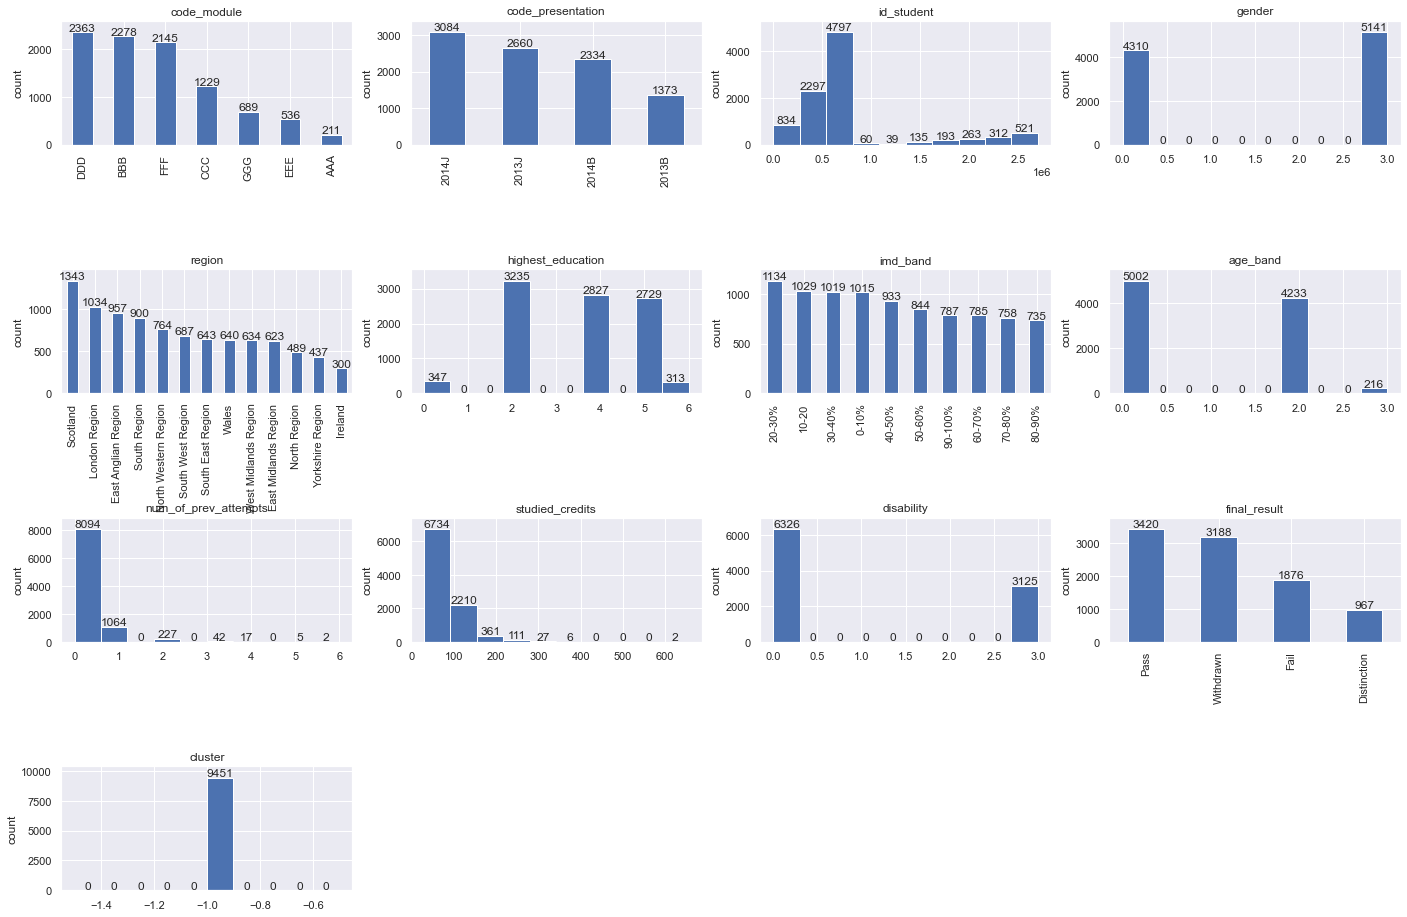

In [772]:
# print(df_outliers.shape[0])
# explore_df(df_outliers)

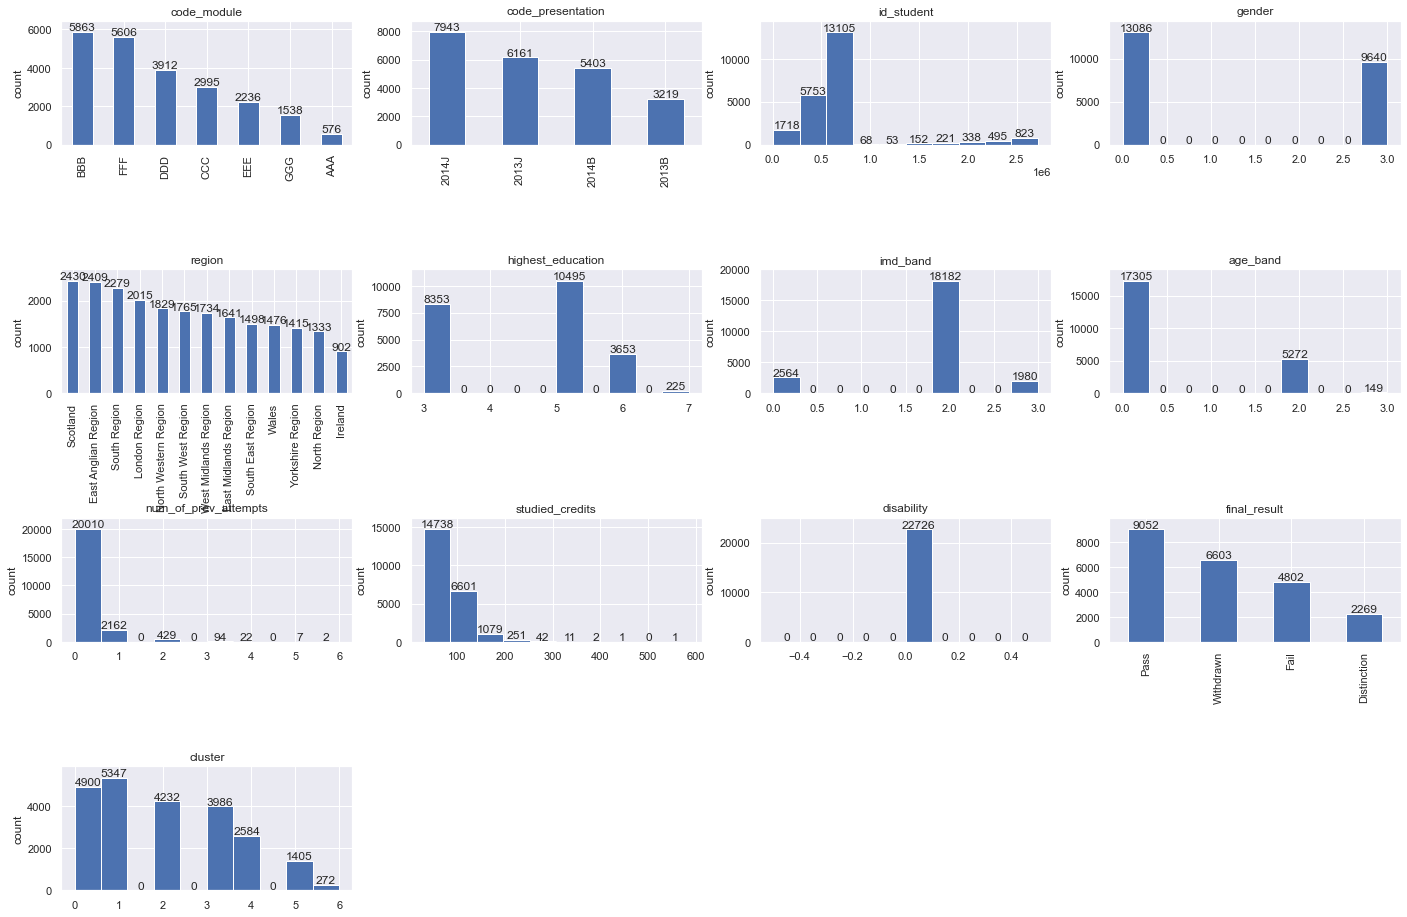

In [689]:
# explore_df(df_reg)

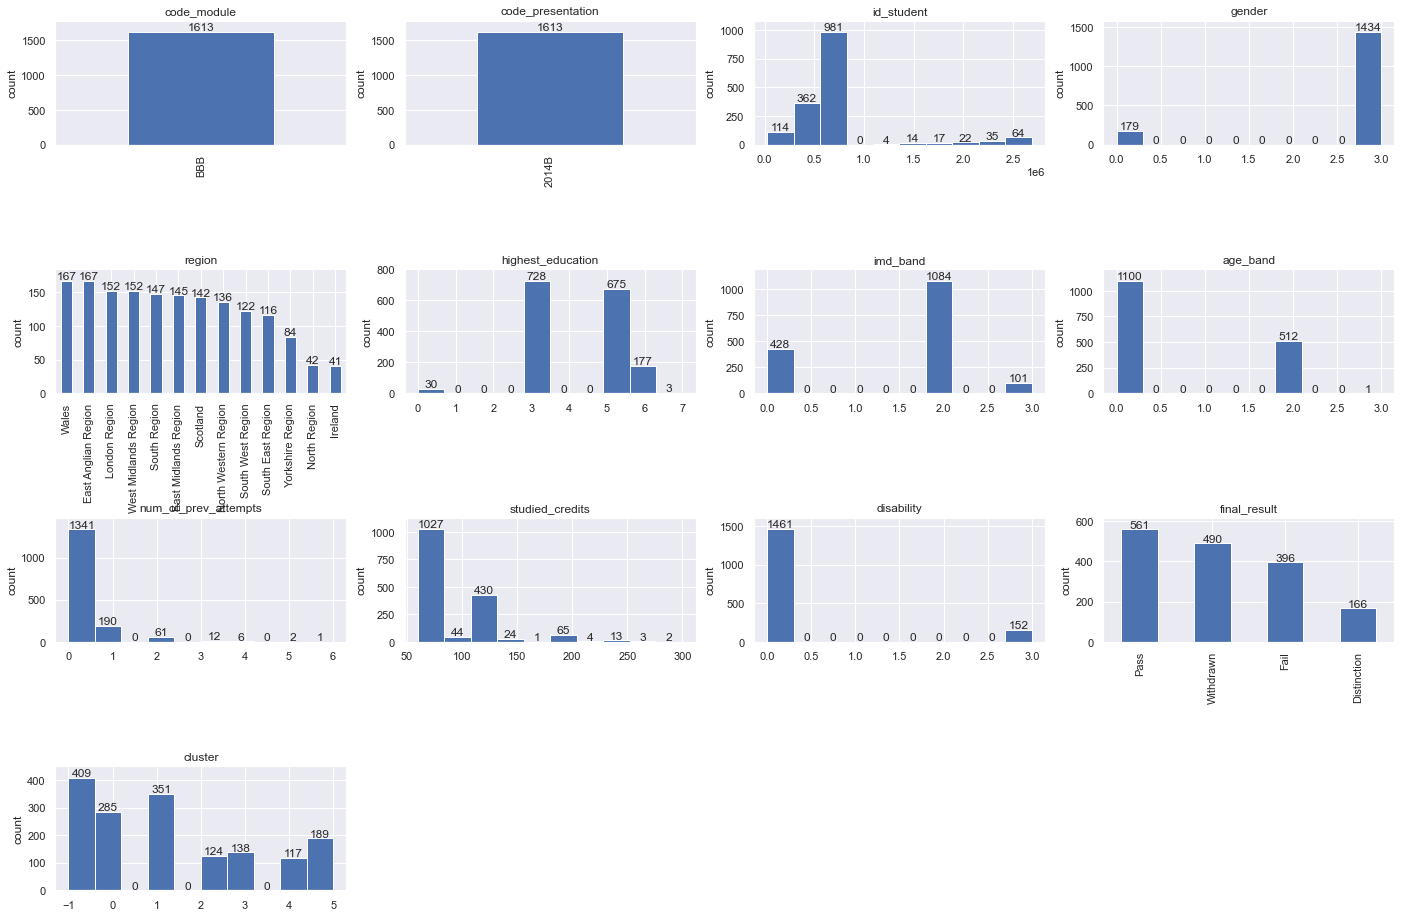

In [742]:
# explore_df(test_[4])

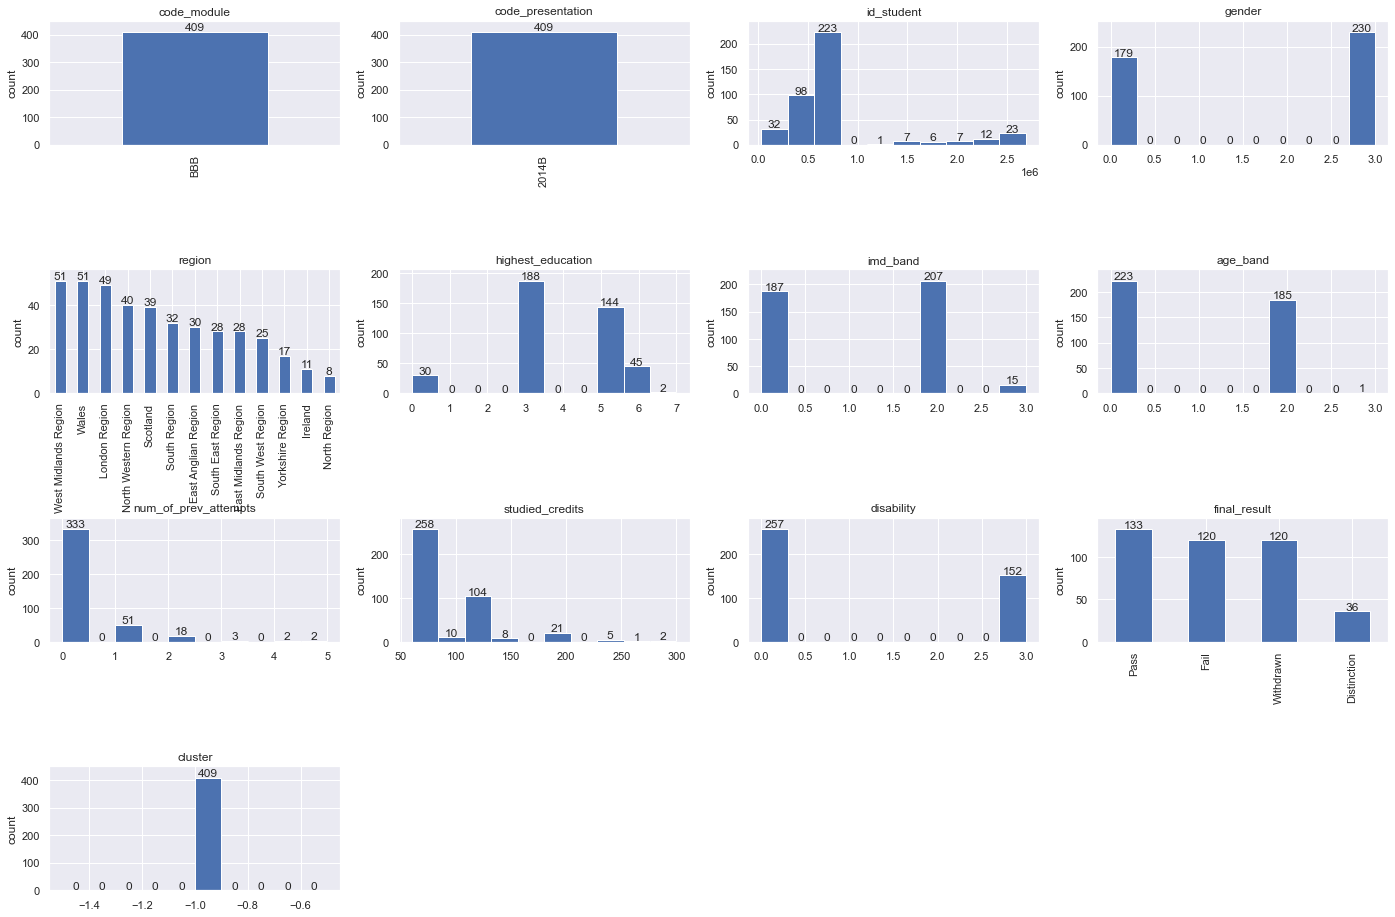

In [743]:
# explore_df(test_[4][(test_[4]['cluster']==-1)  ])

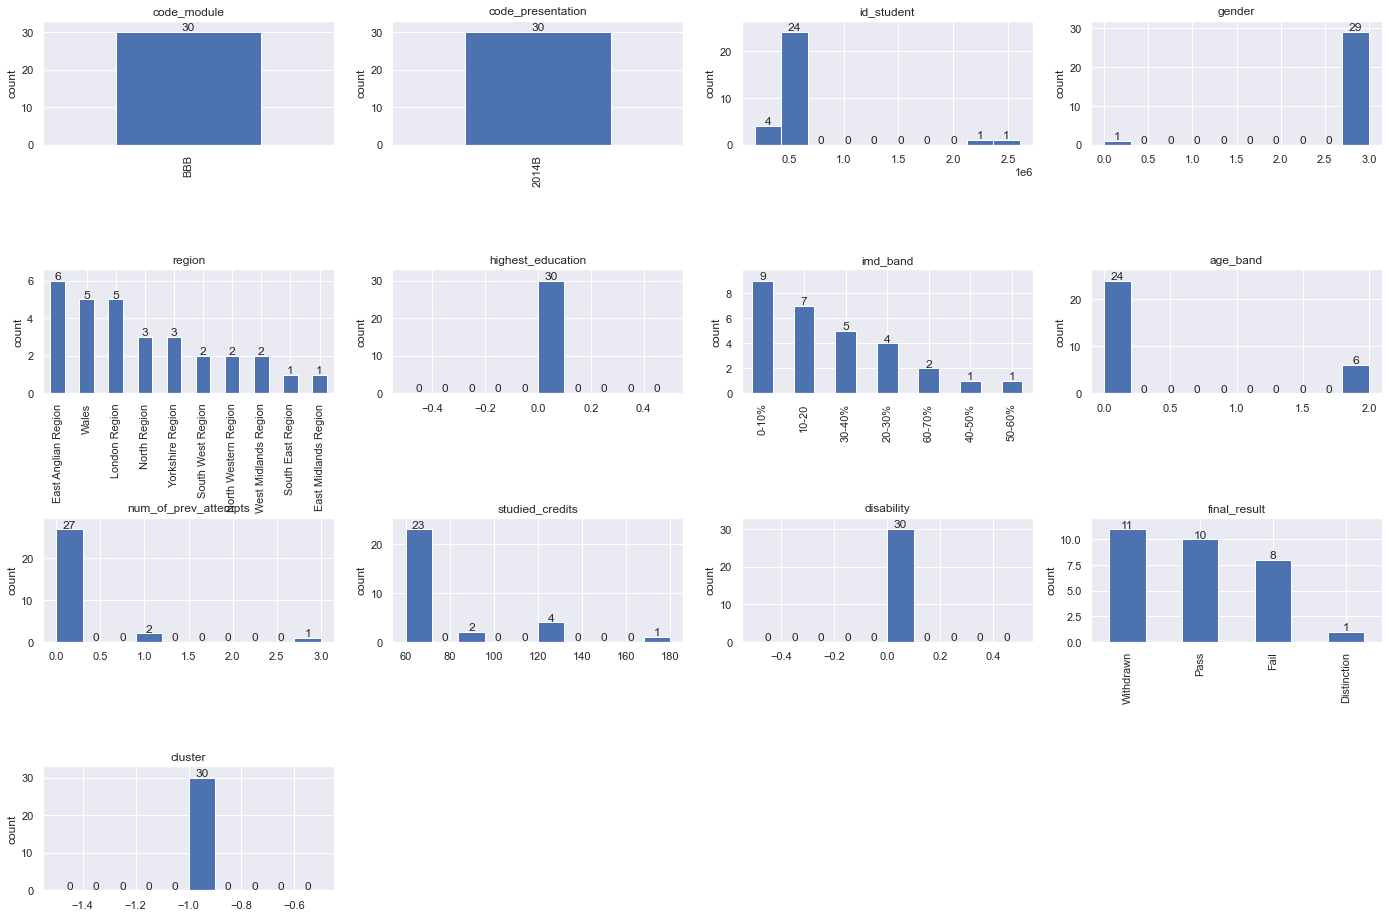

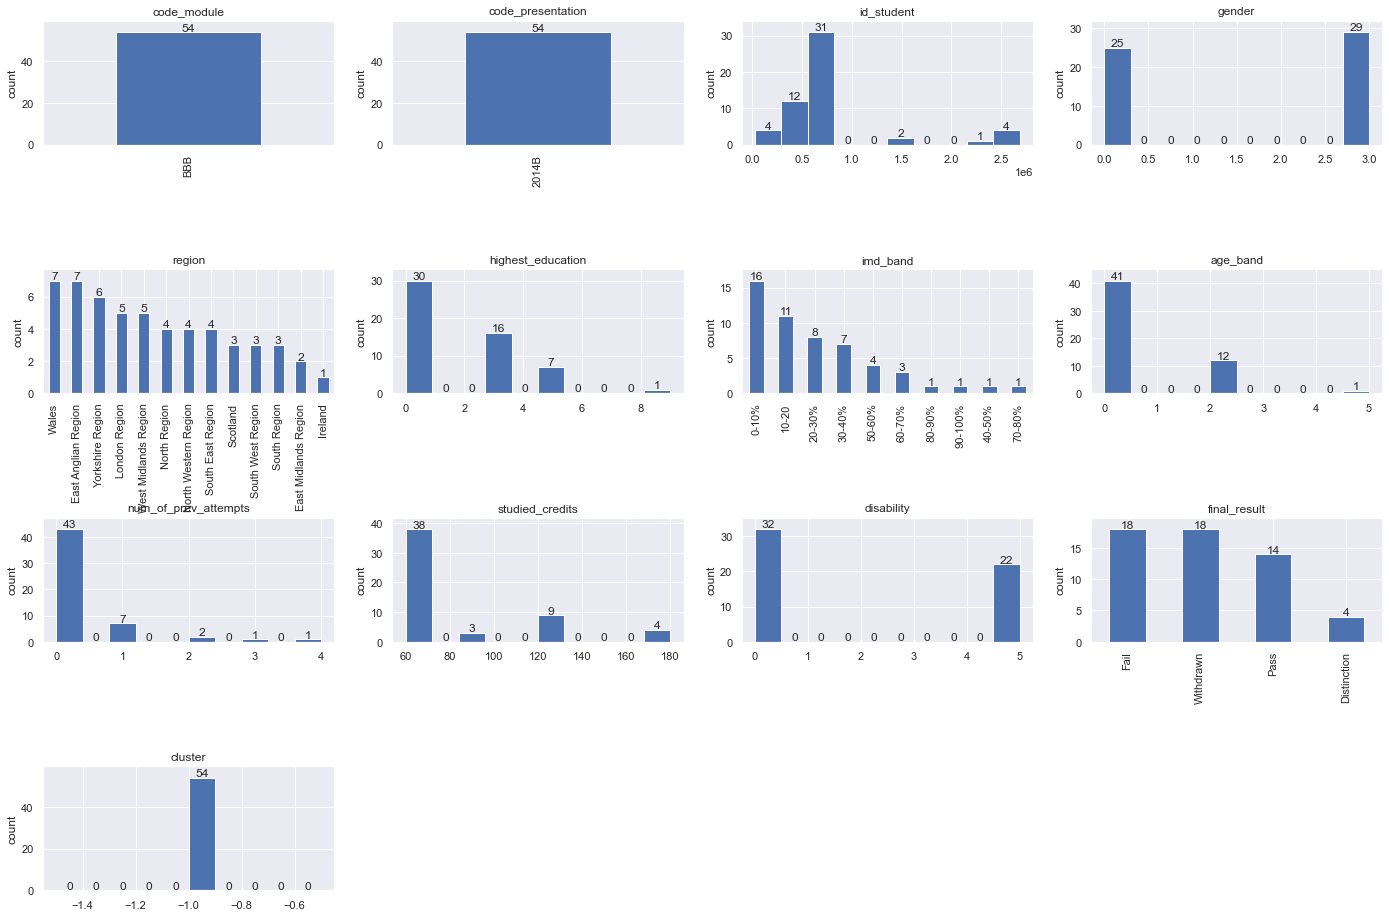

In [400]:
# explore_df(test_[4][(test_[4]['highest_education']==0) & (test_[4]['cluster']==-1)])
# explore_df(test_[4][(test_[4]['cluster']==-1)])